In [2]:
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import sklearn
%matplotlib inline

In [3]:
from mne.viz import plot_connectivity_circle
from matplotlib import cm
sns.set(rc={'figure.figsize':(22,22)})

In [4]:
with open('/external/rprshnas01/netdata_kcni/dflab/team/ma/ukb/imaging/rdsa_subjects_221206.txt', 'r') as f:
    subject_list_rdsa = f.readlines()
subject_list_rdsa = [int(s.strip()) for s in subject_list_rdsa]
print(len(subject_list_rdsa))
print(subject_list_rdsa[0])

30949
4838018


In [5]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection


In [7]:
independent_var = 'duration_of_longest_sleep_bout'
t_values = np.load('representational_connectivity_{}_t_values.npy'.format(independent_var))
p_values = np.load('representational_connectivity_{}_p_values.npy'.format(independent_var))
b_values = np.load('representational_connectivity_{}_b_values.npy'.format(independent_var))


In [4]:
with open('rdsa_rois.txt', 'r') as f:
    roi_list = f.readlines()
roi_list = [s.strip()[11:] for s in roi_list]
roi_list = roi_list[:180]


In [8]:
hcp2yeo_df = pd.read_csv('./freesurfer_label_info/hcp180/hcp_mmp10_yeo7_modes.csv')
dmn_rois = hcp2yeo_df.loc[hcp2yeo_df['Network_Name'] == 'Default', 'ROI_Name'].str.slice(start=2).str.replace('-', '_')
fpn_rois = hcp2yeo_df.loc[hcp2yeo_df['Network_Name'] == 'Frontoparietal', 'ROI_Name'].str.slice(start=2).str.replace('-', '_')
dmn_rois = list(dmn_rois)
fpn_rois = list(fpn_rois)
list(fpn_rois)

['POS2_ROI',
 '7Pm_ROI',
 '8BM_ROI',
 '8Av_ROI',
 '8C_ROI',
 '44_ROI',
 'a47r_ROI',
 'IFJa_ROI',
 'IFSp_ROI',
 'IFSa_ROI',
 'p9_46v_ROI',
 '46_ROI',
 'a9_46v_ROI',
 '9_46d_ROI',
 'a10p_ROI',
 '11l_ROI',
 'i6_8_ROI',
 's6_8_ROI',
 'AVI_ROI',
 'TE1p_ROI',
 'IP2_ROI',
 'IP1_ROI',
 'PFm_ROI',
 'p10p_ROI',
 'p47r_ROI',
 'a32pr_ROI']

In [12]:
def plot_connectivity_separate(con_mat, roi_group1, roi_group2, ic_names, save, color_table=None, var='sleep'):
    if len(roi_group1) >= len(roi_group2):
        start1, end1 = 45, 135
        range2 = 90 * len(roi_group2) / len(roi_group1)
        start2 = 90 - range2/2
        end2 = 90 + range2/2
    else:
        start2, end2 = 45, 135
        range1 = 90 * len(roi_group1) / len(roi_group2)
        start1 = 90 - range1/2
        end1 = 90 + range1/2
    
    first_half = (np.linspace(start1, end1, len(roi_group1)) +90).astype(int)[::+1] %360 #left 
    second_half = (np.linspace(start2, end2, len(roi_group2)) -90).astype(int)[::-1] %360 #right
    node_angles = np.array(list(first_half) + list(second_half))
    con = con_mat.loc[roi_group1 + roi_group2, roi_group1 + roi_group2].values
#     print()
    fig, axes = plt.subplots(1,1, figsize=(20,20), facecolor='w')
    
    con_plot = np.zeros_like(con)
    node_names = roi_group1 + roi_group2
    blank_node_names = ['' for x in node_names]
#     fig, axes = plt.subplots(1,1)
    for idx1 in range(con.shape[0] - 1):
        for idx2 in range(idx1):
            con_plot[:] = np.nan
#             print(con)
            con_plot[idx1, idx2] = con[idx1, idx2]
            con_plot[idx2, idx1] = con[idx2, idx1]
            if np.isnan(con[idx1, idx2]) | (idx1 == idx2):
                continue
            max_width=20
            if (np.nanmax(np.abs(con)) - np.nanmin(np.abs(con[np.nonzero(con)]))) == 0:
                line_width = max_width / 2
            else:
                line_width = ((np.abs(con[idx1, idx2]) - np.nanmin(np.abs(con[np.nonzero(con)]))) * max_width) / (np.nanmax(np.abs(con)) - np.nanmin(np.abs(con[np.nonzero(con)])))  + 0.1*max_width
#             print(node_names)
#             print(node_angles)
            fig, axes = plot_connectivity_circle(con_plot, blank_node_names, 
                                                 node_angles=node_angles, vmin=-np.nanmax(np.abs(con)), vmax=np.nanmax(np.abs(con)), fig=fig, fontsize_names=16, 
                                                 colormap='coolwarm', node_colors=color_table.loc[roi_group1 + roi_group2].values,
                                                 facecolor='white', textcolor='black',
                                                 linewidth=line_width, show=False, colorbar=False)    
    con_plot[:] = np.nan
    fig, axes = plot_connectivity_circle(con_plot, node_names, 
        node_angles=node_angles, vmin=-np.nanmax(np.abs(con)), vmax=np.nanmax(np.abs(con)), fig=fig, fontsize_names=16, 
                                         colormap='coolwarm', node_colors=color_table.loc[roi_group1 + roi_group2].values,
                                        facecolor='white', textcolor='black',
                                        linewidth=1, show=True, colorbar=True)
    if save:
        try:
            
            fig.savefig('{}_representational_conn_{}_230209.pdf'.format(var, ic_names), facecolor='white', dpi=600) 
        except:
            pass

In [13]:
from nibabel.freesurfer.io import read_annot
_, ctab, roi_names_ctab = read_annot('/external/rprshnas01/kcni/mabdelhack/uk_biobank/tfmri/imaging/fsaverage/label/lh.HCP-MMP1.annot')
ctab = ctab[1:, :3]
print(ctab)
roi_names_ctab = [str(x[2:])[2:-1].replace('-', '_') for x in roi_names_ctab[1:]]
print(roi_names_ctab)
ctab_df = pd.DataFrame(data=ctab.byteswap().newbyteorder(), columns=['r', 'g', 'b'], index=roi_names_ctab)
ctab_df = ctab_df/255.
ctab_df.loc[['V1_ROI', 'V2_ROI']]

[[ 63   5 255]
 [ 54 103 129]
 [ 62  78 178]
 [ 23  50 233]
 [ 15  40 226]
 [ 14  28 214]
 [ 26  47 201]
 [ 33 178  20]
 [ 35 205  21]
 [134 143 137]
 [141 166 152]
 [ 62  88  47]
 [  7  57 246]
 [153  64 133]
 [186  86 188]
 [ 18  70 195]
 [ 57 114 160]
 [ 57  89 117]
 [ 25  47 206]
 [  0  49 184]
 [ 18  33 181]
 [ 34  43 171]
 [ 31  86 104]
 [235  19  47]
 [122  79  56]
 [ 31  49  22]
 [138 128 153]
 [142  87  76]
 [149 181 188]
 [ 42  31  44]
 [ 81  54  98]
 [127  56  91]
 [ 29   0  14]
 [ 63  17  47]
 [ 54  11  42]
 [ 48 163  48]
 [153 172 136]
 [205 190 194]
 [ 64 154  64]
 [ 69 161  44]
 [119 159  66]
 [115 194 134]
 [110 146  86]
 [144 179 135]
 [184 243 224]
 [169 246 237]
 [ 68 177 108]
 [ 63 113 158]
 [ 50 129 137]
 [136 206 204]
 [ 20 191  38]
 [ 48 176  62]
 [ 47 216  22]
 [ 26 158  32]
 [ 64 159  38]
 [ 71 168  50]
 [146 136 107]
 [129 106 103]
 [176 133 130]
 [163 142 121]
 [ 67  12  25]
 [ 90  41  50]
 [105  83  81]
 [ 95  32  52]
 [ 25  12   1]
 [ 96  75  66]
 [ 53  54 

,r,g,b
V1_ROI,0.247059,0.019608,1.000000
V2_ROI,0.090196,0.196078,0.913725


In [14]:
ic_pairs = [[dmn_rois, fpn_rois]
           ]
ic_names = ['dmn_fpn'] #, '18_12', '16_13', '18_2'

In [ ]:
t_values = np.load('representational_connectivity_{}_t_values.npy'.format(independent_var))
p_values = np.load('representational_connectivity_{}_p_values.npy'.format(independent_var))
b_values = np.load('representational_connectivity_{}_b_values.npy'.format(independent_var))

for ic_pair, ic_name in zip(ic_pairs, ic_names):
    print(ic_pair)
    plot_connectivity_separate(b_values_fdr_df, ic_pair[0], ic_pair[1], ic_name, True, ctab_df)

duration_of_longest_sleep_bout
[['RSC_ROI', 'SFL_ROI', '7m_ROI', 'POS1_ROI', '23d_ROI', 'v23ab_ROI', 'd23ab_ROI', '31pv_ROI', 'a24_ROI', 'd32_ROI', 'p32_ROI', '10r_ROI', '47m_ROI', '8Ad_ROI', '9m_ROI', '8BL_ROI', '9p_ROI', '10d_ROI', '45_ROI', '47l_ROI', '9a_ROI', '47s_ROI', 'STGa_ROI', 'STSda_ROI', 'STSdp_ROI', 'STSvp_ROI', 'TE1a_ROI', 'PGi_ROI', 'PGs_ROI', '31pd_ROI', '31a_ROI', 's32_ROI', 'STSva_ROI', 'TE1m_ROI', 'p24_ROI'], ['POS2_ROI', '7Pm_ROI', '8BM_ROI', '8Av_ROI', '8C_ROI', '44_ROI', 'a47r_ROI', 'IFJa_ROI', 'IFSp_ROI', 'IFSa_ROI', 'p9_46v_ROI', '46_ROI', 'a9_46v_ROI', '9_46d_ROI', 'a10p_ROI', '11l_ROI', 'i6_8_ROI', 's6_8_ROI', 'AVI_ROI', 'TE1p_ROI', 'IP2_ROI', 'IP1_ROI', 'PFm_ROI', 'p10p_ROI', 'p47r_ROI', 'a32pr_ROI']]


/external/rprshnas01/kcni/mabdelhack/viz/lib64/python3.6/site-packages/mne/viz/circle.py:283: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axes = plt.subplot(*subplot, polar=True)


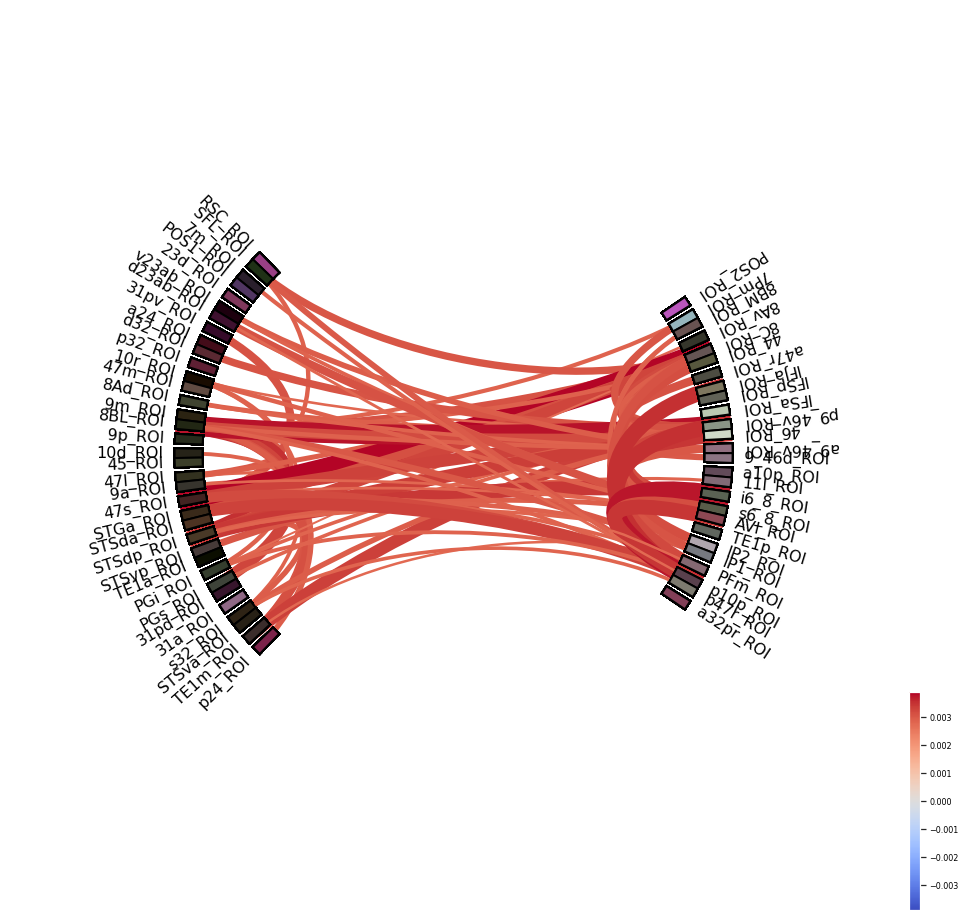

Sleeplessness___insomnia
[['RSC_ROI', 'SFL_ROI', '7m_ROI', 'POS1_ROI', '23d_ROI', 'v23ab_ROI', 'd23ab_ROI', '31pv_ROI', 'a24_ROI', 'd32_ROI', 'p32_ROI', '10r_ROI', '47m_ROI', '8Ad_ROI', '9m_ROI', '8BL_ROI', '9p_ROI', '10d_ROI', '45_ROI', '47l_ROI', '9a_ROI', '47s_ROI', 'STGa_ROI', 'STSda_ROI', 'STSdp_ROI', 'STSvp_ROI', 'TE1a_ROI', 'PGi_ROI', 'PGs_ROI', '31pd_ROI', '31a_ROI', 's32_ROI', 'STSva_ROI', 'TE1m_ROI', 'p24_ROI'], ['POS2_ROI', '7Pm_ROI', '8BM_ROI', '8Av_ROI', '8C_ROI', '44_ROI', 'a47r_ROI', 'IFJa_ROI', 'IFSp_ROI', 'IFSa_ROI', 'p9_46v_ROI', '46_ROI', 'a9_46v_ROI', '9_46d_ROI', 'a10p_ROI', '11l_ROI', 'i6_8_ROI', 's6_8_ROI', 'AVI_ROI', 'TE1p_ROI', 'IP2_ROI', 'IP1_ROI', 'PFm_ROI', 'p10p_ROI', 'p47r_ROI', 'a32pr_ROI']]


/external/rprshnas01/kcni/mabdelhack/viz/lib64/python3.6/site-packages/mne/viz/circle.py:283: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axes = plt.subplot(*subplot, polar=True)


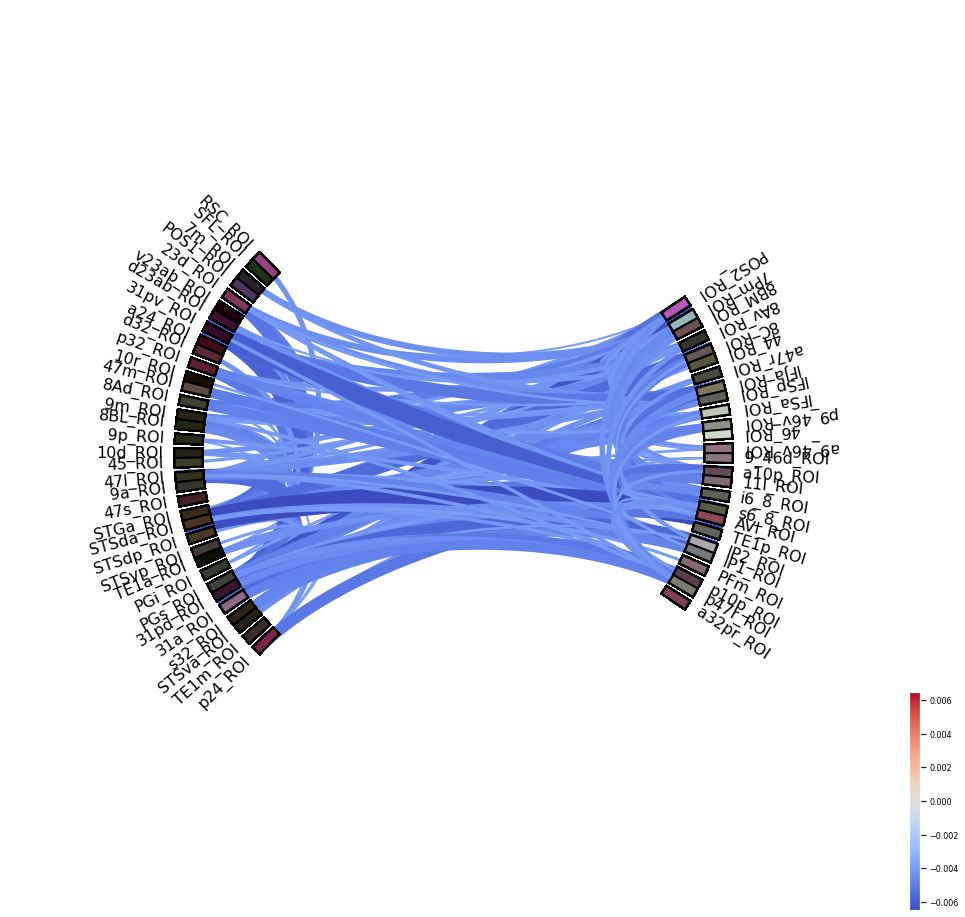

Number_of_symbol_digit_matches_made_correctly
[['RSC_ROI', 'SFL_ROI', '7m_ROI', 'POS1_ROI', '23d_ROI', 'v23ab_ROI', 'd23ab_ROI', '31pv_ROI', 'a24_ROI', 'd32_ROI', 'p32_ROI', '10r_ROI', '47m_ROI', '8Ad_ROI', '9m_ROI', '8BL_ROI', '9p_ROI', '10d_ROI', '45_ROI', '47l_ROI', '9a_ROI', '47s_ROI', 'STGa_ROI', 'STSda_ROI', 'STSdp_ROI', 'STSvp_ROI', 'TE1a_ROI', 'PGi_ROI', 'PGs_ROI', '31pd_ROI', '31a_ROI', 's32_ROI', 'STSva_ROI', 'TE1m_ROI', 'p24_ROI'], ['POS2_ROI', '7Pm_ROI', '8BM_ROI', '8Av_ROI', '8C_ROI', '44_ROI', 'a47r_ROI', 'IFJa_ROI', 'IFSp_ROI', 'IFSa_ROI', 'p9_46v_ROI', '46_ROI', 'a9_46v_ROI', '9_46d_ROI', 'a10p_ROI', '11l_ROI', 'i6_8_ROI', 's6_8_ROI', 'AVI_ROI', 'TE1p_ROI', 'IP2_ROI', 'IP1_ROI', 'PFm_ROI', 'p10p_ROI', 'p47r_ROI', 'a32pr_ROI']]


/external/rprshnas01/kcni/mabdelhack/viz/lib64/python3.6/site-packages/mne/viz/circle.py:283: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axes = plt.subplot(*subplot, polar=True)


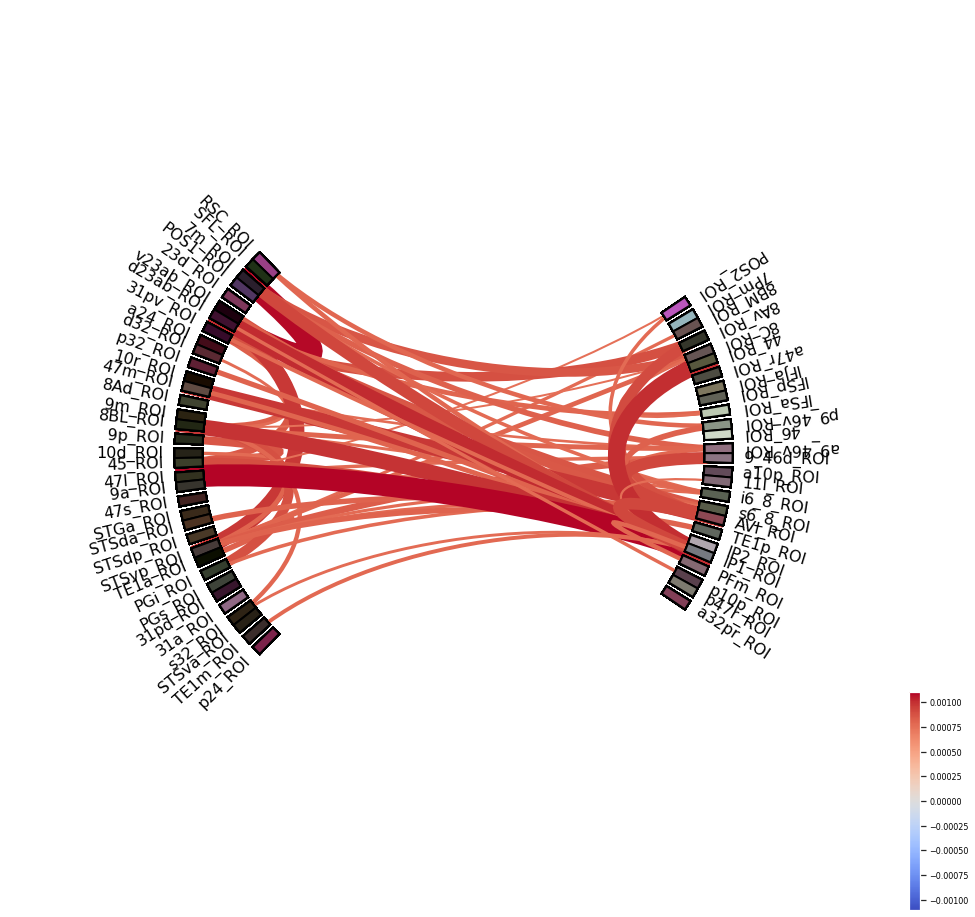

phq2
[['RSC_ROI', 'SFL_ROI', '7m_ROI', 'POS1_ROI', '23d_ROI', 'v23ab_ROI', 'd23ab_ROI', '31pv_ROI', 'a24_ROI', 'd32_ROI', 'p32_ROI', '10r_ROI', '47m_ROI', '8Ad_ROI', '9m_ROI', '8BL_ROI', '9p_ROI', '10d_ROI', '45_ROI', '47l_ROI', '9a_ROI', '47s_ROI', 'STGa_ROI', 'STSda_ROI', 'STSdp_ROI', 'STSvp_ROI', 'TE1a_ROI', 'PGi_ROI', 'PGs_ROI', '31pd_ROI', '31a_ROI', 's32_ROI', 'STSva_ROI', 'TE1m_ROI', 'p24_ROI'], ['POS2_ROI', '7Pm_ROI', '8BM_ROI', '8Av_ROI', '8C_ROI', '44_ROI', 'a47r_ROI', 'IFJa_ROI', 'IFSp_ROI', 'IFSa_ROI', 'p9_46v_ROI', '46_ROI', 'a9_46v_ROI', '9_46d_ROI', 'a10p_ROI', '11l_ROI', 'i6_8_ROI', 's6_8_ROI', 'AVI_ROI', 'TE1p_ROI', 'IP2_ROI', 'IP1_ROI', 'PFm_ROI', 'p10p_ROI', 'p47r_ROI', 'a32pr_ROI']]


/external/rprshnas01/kcni/mabdelhack/viz/lib64/python3.6/site-packages/mne/viz/circle.py:283: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axes = plt.subplot(*subplot, polar=True)


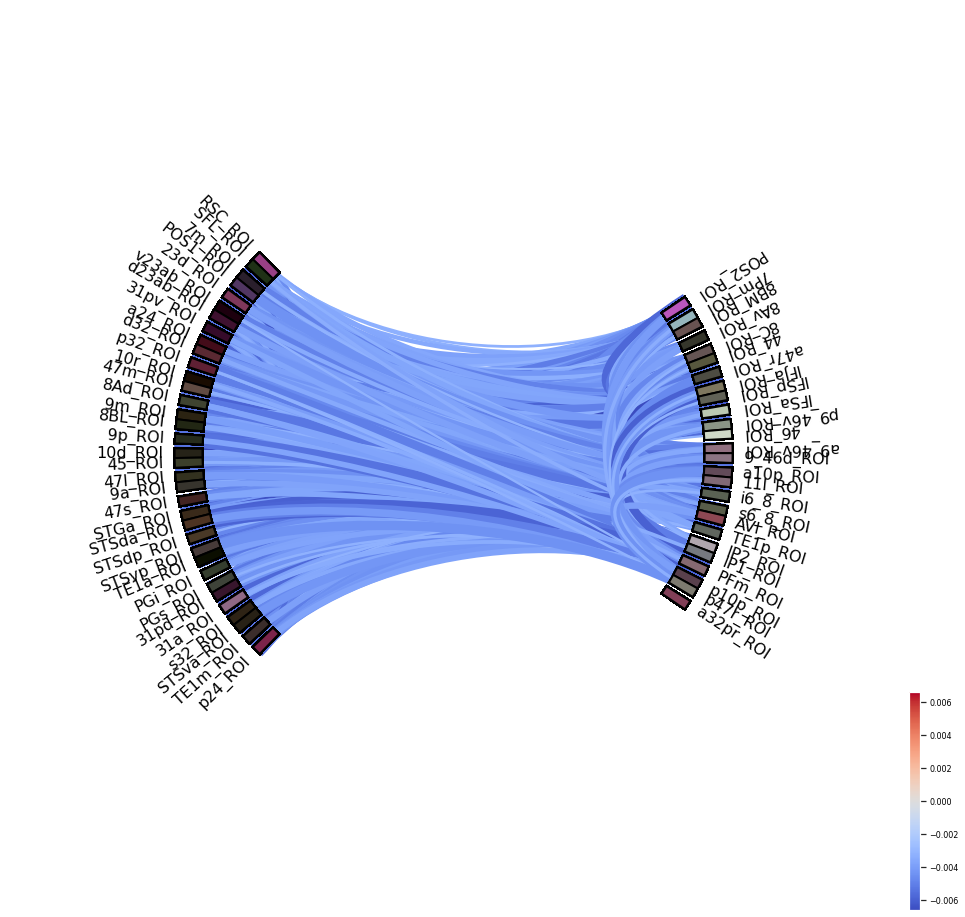

Daytime_dozing___sleeping_narcolepsy
[['RSC_ROI', 'SFL_ROI', '7m_ROI', 'POS1_ROI', '23d_ROI', 'v23ab_ROI', 'd23ab_ROI', '31pv_ROI', 'a24_ROI', 'd32_ROI', 'p32_ROI', '10r_ROI', '47m_ROI', '8Ad_ROI', '9m_ROI', '8BL_ROI', '9p_ROI', '10d_ROI', '45_ROI', '47l_ROI', '9a_ROI', '47s_ROI', 'STGa_ROI', 'STSda_ROI', 'STSdp_ROI', 'STSvp_ROI', 'TE1a_ROI', 'PGi_ROI', 'PGs_ROI', '31pd_ROI', '31a_ROI', 's32_ROI', 'STSva_ROI', 'TE1m_ROI', 'p24_ROI'], ['POS2_ROI', '7Pm_ROI', '8BM_ROI', '8Av_ROI', '8C_ROI', '44_ROI', 'a47r_ROI', 'IFJa_ROI', 'IFSp_ROI', 'IFSa_ROI', 'p9_46v_ROI', '46_ROI', 'a9_46v_ROI', '9_46d_ROI', 'a10p_ROI', '11l_ROI', 'i6_8_ROI', 's6_8_ROI', 'AVI_ROI', 'TE1p_ROI', 'IP2_ROI', 'IP1_ROI', 'PFm_ROI', 'p10p_ROI', 'p47r_ROI', 'a32pr_ROI']]


/external/rprshnas01/kcni/mabdelhack/viz/lib64/python3.6/site-packages/mne/viz/circle.py:283: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axes = plt.subplot(*subplot, polar=True)


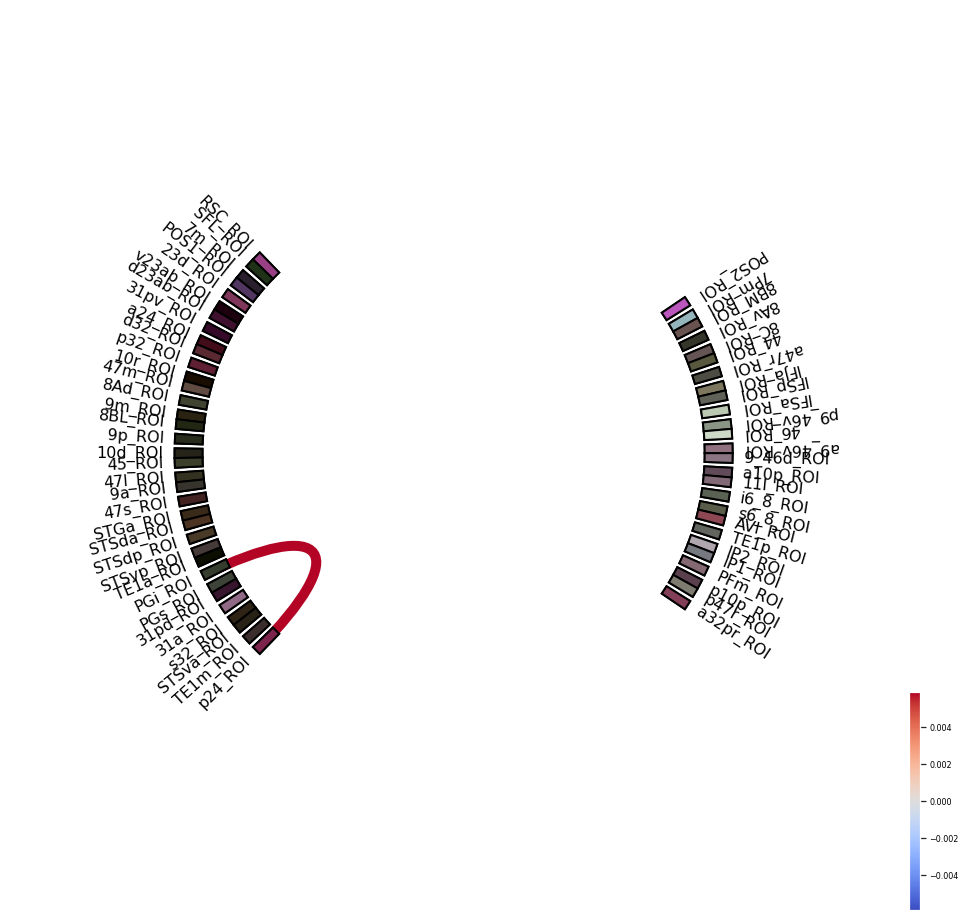

In [22]:
for independent_var in ['duration_of_longest_sleep_bout', 
                        'Sleeplessness___insomnia', 
                        'Number_of_symbol_digit_matches_made_correctly', 
                        'phq2',
                       'Daytime_dozing___sleeping_narcolepsy']:
    t_values = np.load('representational_connectivity_{}_t_values.npy'.format(independent_var))
    p_values = np.load('representational_connectivity_{}_p_values.npy'.format(independent_var))
    b_values = np.load('representational_connectivity_{}_b_values.npy'.format(independent_var))
    p_values_fdr = np.zeros((180, 180))
    print(independent_var)
    p_values_fdr_flat = p_values[np.triu_indices(180, 1)]
    if (p_values_fdr_flat > 0.05/5).all():
        print('{} has no significant difference'.format(independent_var))
        continue
    p_values_fdr = p_values
    p_values_fdr = p_values_fdr + p_values_fdr.T
#     print(t_values)
    b_values_fdr = b_values
    b_values_fdr[p_values_fdr > 0.05/5] = np.nan
    b_values_fdr = b_values_fdr + b_values_fdr.T
    b_values_fdr_df = pd.DataFrame(b_values_fdr, index=roi_list, columns=roi_list)
    
    for ic_pair, ic_name in zip(ic_pairs, ic_names):
        print(ic_pair)
        plot_connectivity_separate(b_values_fdr_df, ic_pair[0], ic_pair[1], ic_name, True, ctab_df)

duration_of_longest_sleep_bout
Sleeplessness___insomnia
Number_of_symbol_digit_matches_made_correctly
phq2
Daytime_dozing___sleeping_narcolepsy


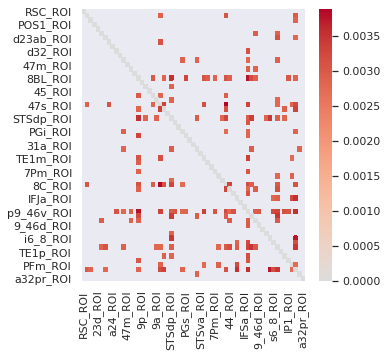

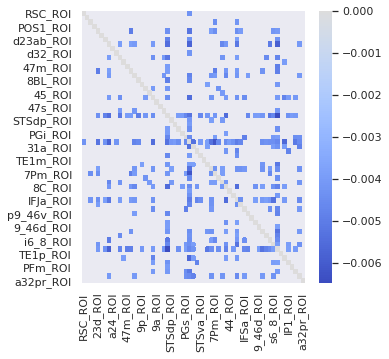

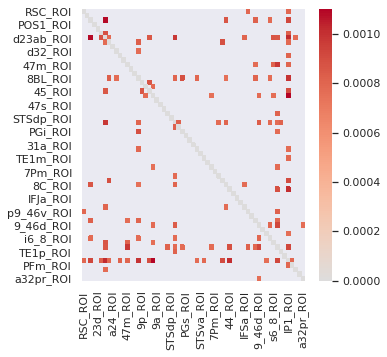

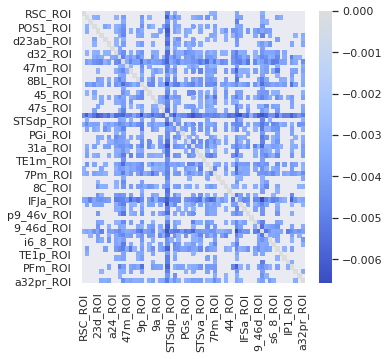

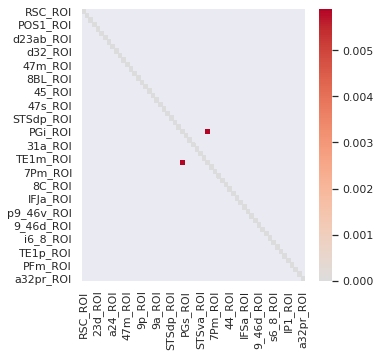

In [26]:
for independent_var in ['duration_of_longest_sleep_bout', 
                        'Sleeplessness___insomnia', 
                        'Number_of_symbol_digit_matches_made_correctly', 
                        'phq2',
                       'Daytime_dozing___sleeping_narcolepsy']:
    t_values = np.load('representational_connectivity_{}_t_values.npy'.format(independent_var))
    p_values = np.load('representational_connectivity_{}_p_values.npy'.format(independent_var))
    b_values = np.load('representational_connectivity_{}_b_values.npy'.format(independent_var))
    p_values_fdr = np.zeros((180, 180))
    print(independent_var)
    p_values_fdr_flat = p_values[np.triu_indices(180, 1)]
    if (p_values_fdr_flat > 0.05/5).all():
        print('{} has no significant difference'.format(independent_var))
        continue
    p_values_fdr = p_values
    p_values_fdr = p_values_fdr + p_values_fdr.T
#     print(t_values)
    b_values_fdr = b_values
    b_values_fdr[p_values_fdr > 0.05/5] = np.nan
    b_values_fdr = b_values_fdr + b_values_fdr.T
    b_values_fdr_df = pd.DataFrame(b_values_fdr, index=roi_list, columns=roi_list)
    
    for ic_pair, ic_name in zip(ic_pairs, ic_names):
#         print(ic_pair)
        fig, axes = plt.subplots(1,1, figsize=(5,5), facecolor='w')
        sns.heatmap(b_values_fdr_df.loc[ic_pair[0] + ic_pair[1], ic_pair[0] + ic_pair[1]], cmap='coolwarm', center=0)

duration_of_longest_sleep_bout
Sleeplessness___insomnia
Number_of_symbol_digit_matches_made_correctly
phq2
Daytime_dozing___sleeping_narcolepsy


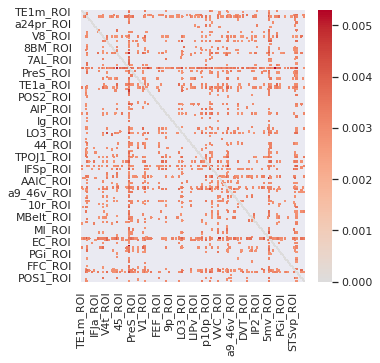

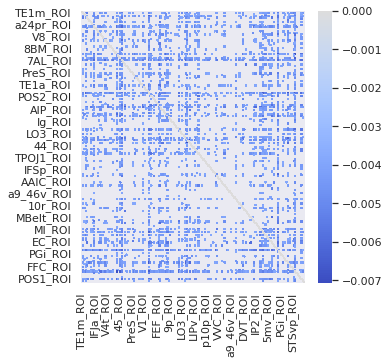

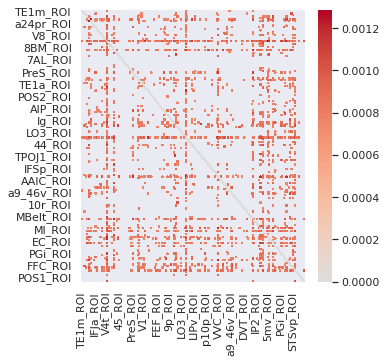

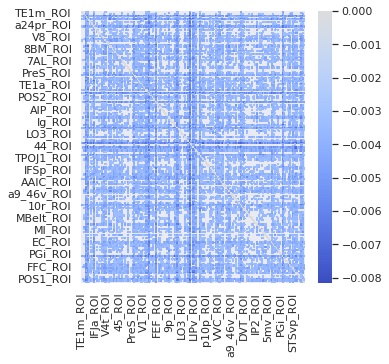

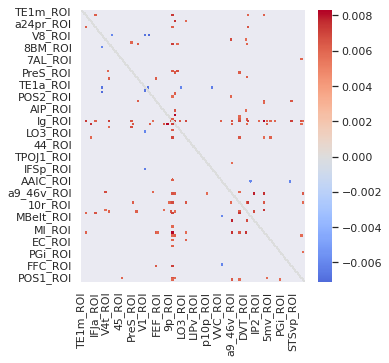

In [27]:
for independent_var in ['duration_of_longest_sleep_bout', 
                        'Sleeplessness___insomnia', 
                        'Number_of_symbol_digit_matches_made_correctly', 
                        'phq2',
                       'Daytime_dozing___sleeping_narcolepsy']:
    t_values = np.load('representational_connectivity_{}_t_values.npy'.format(independent_var))
    p_values = np.load('representational_connectivity_{}_p_values.npy'.format(independent_var))
    b_values = np.load('representational_connectivity_{}_b_values.npy'.format(independent_var))
    p_values_fdr = np.zeros((180, 180))
    print(independent_var)
    p_values_fdr_flat = p_values[np.triu_indices(180, 1)]
    if (p_values_fdr_flat > 0.05/5).all():
        print('{} has no significant difference'.format(independent_var))
        continue
    p_values_fdr = p_values
    p_values_fdr = p_values_fdr + p_values_fdr.T
#     print(t_values)
    b_values_fdr = b_values
    b_values_fdr[p_values_fdr > 0.05/5] = np.nan
    b_values_fdr = b_values_fdr + b_values_fdr.T
    b_values_fdr_df = pd.DataFrame(b_values_fdr, index=roi_list, columns=roi_list)
    
    for ic_pair, ic_name in zip(ic_pairs, ic_names):
#         print(ic_pair)
        fig, axes = plt.subplots(1,1, figsize=(5,5), facecolor='w')
        sns.heatmap(b_values_fdr_df, cmap='coolwarm', center=0)

In [18]:
for independent_var in ['duration_of_longest_sleep_bout', 
                        'Sleeplessness___insomnia', 
                        'Number_of_symbol_digit_matches_made_correctly', 
                        'phq2',
                       'Daytime_dozing___sleeping_narcolepsy']:
    t_values = np.load('representational_connectivity_{}_t_values.npy'.format(independent_var))
    p_values = np.load('representational_connectivity_{}_p_values.npy'.format(independent_var))
    b_values = np.load('representational_connectivity_{}_b_values.npy'.format(independent_var))
    p_values_fdr = np.zeros((180, 180))
    print(independent_var)
    p_values_fdr_flat = p_values[np.triu_indices(180, 1)]
    if (p_values_fdr_flat > 0.05/5).all():
        print('{} has no significant difference'.format(independent_var))
        continue
    p_values_fdr = p_values
    p_values_fdr = p_values_fdr + p_values_fdr.T
#     print(t_values)
    b_values_fdr = b_values
    b_values_fdr[p_values_fdr > 0.05/5] = np.nan
    b_values_fdr = b_values_fdr + b_values_fdr.T
    b_values_fdr_df = pd.DataFrame(b_values_fdr, index=roi_list, columns=roi_list)
    print(roi_list[np.triu_indices(180, 1)[0][p_values[np.triu_indices(180, 1)].argmin()]])
    print(roi_list[np.triu_indices(180, 1)[1][p_values[np.triu_indices(180, 1)].argmin()]])
    print(p_values[np.triu_indices(180, 1)].min())
    print(p_values[np.triu_indices(180, 1)].argmin())
    print(b_values[np.triu_indices(180, 1)][p_values[np.triu_indices(180, 1)].argmin()])
    

duration_of_longest_sleep_bout
FOP2_ROI
9_46d_ROI
8.934932828216902e-07
6216
0.005303528801148991
Sleeplessness___insomnia
5m_ROI
VIP_ROI
2.8202656816461195e-06
11646
-0.007064898390924681
Number_of_symbol_digit_matches_made_correctly
V4t_ROI
5mv_ROI
1.2697032875745428e-05
3519
0.0012863149420336048
phq2
V4_ROI
VIP_ROI
1.8834112892375802e-11
617
-0.008144036009972423
Daytime_dozing___sleeping_narcolepsy
PFt_ROI
46_ROI
0.0002260642204450668
10512
0.008317551923961896


In [14]:
b_values[np.triu_indices(180, 1)][p_values[np.triu_indices(180, 1)] == p_values[np.triu_indices(180, 1)].min()]

array([0.00831755])

In [21]:
b_values

array([[ 0., nan, nan, ..., nan, nan, nan],
       [nan,  0., nan, ..., nan, nan, nan],
       [nan, nan,  0., ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ...,  0., nan, nan],
       [nan, nan, nan, ..., nan,  0., nan],
       [nan, nan, nan, ..., nan, nan,  0.]])

In [45]:
variables_presentable = ['Duration of longest sleep bout', 'PHQ-2', 'Cognition', 'Self-report insomnia', 'Self-report daytime dozing']
assoc_stats_df = pd.DataFrame(columns=['Variable', 'Node 1', 'Node 2', 'Coefficient', 't-value', 'p-value (raw)', 'p-value (Bonferroni)', 'Significant'],
                                 index=np.arange(16110 * 5))
for idx, var in enumerate(['duration_of_longest_sleep_bout', 
                        'Sleeplessness___insomnia', 
                        'Number_of_symbol_digit_matches_made_correctly', 
                        'phq2',
                       'Daytime_dozing___sleeping_narcolepsy']):
    t_values = np.load('representational_connectivity_{}_t_values.npy'.format(var))
    p_values = np.load('representational_connectivity_{}_p_values.npy'.format(var))
    b_values = np.load('representational_connectivity_{}_b_values.npy'.format(var))
    assoc_stats_df.loc[idx*16110:(idx+1)*16110-1, 'Variable'] = variables_presentable[idx]
    assoc_stats_df.loc[idx*16110:(idx+1)*16110-1, 'Node 1'] = np.array(roi_list_presentable)[np.triu_indices(180, 1)[0]]
    assoc_stats_df.loc[idx*16110:(idx+1)*16110-1, 'Node 2'] = np.array(roi_list_presentable)[np.triu_indices(180, 1)[1]]
    assoc_stats_df.loc[idx*16110:(idx+1)*16110-1, 'Coefficient'] = b_values[np.triu_indices(180, 1)]
    assoc_stats_df.loc[idx*16110:(idx+1)*16110-1, 't-value'] = t_values[np.triu_indices(180, 1)]
    assoc_stats_df.loc[idx*16110:(idx+1)*16110-1, 'p-value (raw)'] = p_values[np.triu_indices(180, 1)]
    assoc_stats_df.loc[idx*16110:(idx+1)*16110-1, 'p-value (Bonferroni)'] = p_values[np.triu_indices(180, 1)] * 5
    assoc_stats_df.loc[idx*16110:(idx+1)*16110-1, 'Significant'] = p_values[np.triu_indices(180, 1)] * 5 < 0.05
assoc_stats_df.to_csv('./stats_supplement/representational_connectivity_association_statistics.csv'.format(var), index=False)



In [33]:
roi_list_presentable = [x[:-4].replace('_', '-') for x in roi_list]
roi_list_presentable

['TE1m',
 'TGd',
 'TE2p',
 'V4',
 'VMV3',
 'V3',
 'd23ab',
 'PHA2',
 'a24pr',
 '10v',
 'IFJa',
 'FOP5',
 '3b',
 'p47r',
 's32',
 '31pv',
 'V8',
 'MIP',
 '4',
 'STV',
 'V4t',
 'SCEF',
 '6r',
 'p32',
 '8BM',
 'PGs',
 'PF',
 'V3CD',
 'pOFC',
 'TPOJ3',
 '45',
 'TF',
 '7AL',
 'PBelt',
 '24dd',
 '1',
 'STGa',
 'STSva',
 'FOP2',
 'V7',
 'PreS',
 '47l',
 'a10p',
 'PSL',
 '11l',
 '55b',
 'PFop',
 'a47r',
 'TE1a',
 '8C',
 'V1',
 'p9-46v',
 'PH',
 '24dv',
 'STSda',
 '9m',
 'POS2',
 'PIT',
 'IFSa',
 'TE1p',
 'FEF',
 'Pir',
 'PeEc',
 'PEF',
 'AIP',
 'i6-8',
 'H',
 'LIPd',
 'PoI1',
 'PoI2',
 '9p',
 '10d',
 'Ig',
 'PFt',
 'LO1',
 '3a',
 'LO2',
 'p24pr',
 'PHT',
 'IP0',
 'LO3',
 'OFC',
 'V2',
 '31a',
 'V3B',
 '5m',
 'MST',
 'VIP',
 '44',
 '7m',
 'LIPv',
 's6-8',
 'VMV1',
 '23c',
 '52',
 'PHA1',
 'TPOJ1',
 'STSdp',
 'V6A',
 '7PC',
 'p10p',
 'a24',
 'TGv',
 'FOP4',
 'IFSp',
 'TA2',
 'a32pr',
 'OP4',
 '7Pm',
 '6mp',
 'VVC',
 '33pr',
 'AAIC',
 '8Ad',
 '2',
 '8Av',
 '9a',
 '8BL',
 'PCV',
 '43',
 'a9-46v',


In [44]:
np.array(roi_list_presentable)[np.triu_indices(180, 1)[0]]

array(['TE1m', 'TE1m', 'TE1m', ..., '6d', '6d', 'p24'], dtype='<U6')

In [40]:
np.triu_indices(180, 1)[0].astype(int).dtype

dtype('int64')